In [1]:
import pandas as pd
import datetime
import sys
sys.path.append('./utils')
from utils import *
from process import * 
from add_list_master import *
import japanize_matplotlib

In [2]:
# データ保存先
data_folda = '../data/'

target_column="target3"
make_genre_list=True

In [13]:
# 説明変数のリスト
explain_columns=base_info+add_list_master+add_list_hitosara+add_list_retty+add_list_tripadvisor+add_list_google+add_list_hotpepper
# 重複を削除
explain_columns=list(set(explain_columns))

In [3]:
pseudo_time_series_with = extract_features(data_folda,"train_with_master_structured_main_medias.pkl",explain_columns, target_column)
#non bias dataも読み込む
if(target_column=="target3"):
    pseudo_time_series_with_non_bias = extract_features(data_folda,"test3_with_master_structured_main_medias.pkl",explain_columns, target_column)
elif(target_column=="target6"):
    pseudo_time_series_with_non_bias = extract_features(data_folda,"test6_with_master_structured_main_medias.pkl",explain_columns, target_column)
    

In [4]:
close_ratios=pd.read_pickle(data_folda+'close_ratios.pkl')
pseudo_time_series_with=pd.merge(pseudo_time_series_with,close_ratios,on=["base_date","genre_first_name"],how="left")
pseudo_time_series_with_non_bias=pd.merge(pseudo_time_series_with_non_bias,close_ratios,on=["base_date","genre_first_name"],how="left")

In [9]:
if(make_genre_list==True):
    # genreのリストを作成
    genre0=pseudo_time_series_with["genre_first_name"].unique()
    genre1=pseudo_time_series_with["genre_second_name"].unique()
    genre2=pseudo_time_series_with["genre_third_name"].unique()
    
    genre_list = list(set(list(genre0)+list(genre1)+list(genre2)))
    #毎回読み込むのは時間がかかるので、一度読み込んだらpickleで保存しておく
    genre_list = pd.Series(genre_list)
    genre_list.dropna().to_pickle(data_folda+'genre_list.pkl')
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()
else:
    # 保存しておいたgenre_listを、listとして読み込む
    genre_list = pd.read_pickle(data_folda+'genre_list.pkl').dropna().to_list()

In [10]:
base_month_1="202301"
pseudo_time_series_with_1 = make_train_data(pseudo_time_series_with, base_month_1, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/220 [00:00<?, ?it/s]

In [14]:
base_month_4="202304"
pseudo_time_series_with_4 = make_train_data(pseudo_time_series_with, base_month_4, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/220 [00:00<?, ?it/s]

In [15]:
base_month_7="202307"
pseudo_time_series_with_7 = make_train_data(pseudo_time_series_with, base_month_7, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/220 [00:00<?, ?it/s]

In [44]:
# augumented_data_train_1とaugumented_data_train_2を結合
pseudo_time_series_train=pd.concat([pseudo_time_series_with_4
                                    ,pseudo_time_series_with_7])


if(target_column=="target6"):
    pseudo_time_series_train=pd.concat([pseudo_time_series_with_1
                                    ,pseudo_time_series_with_4])
#del pseudo_time_series_with_0, pseudo_time_series_with_4


In [63]:
base_month_test="202311"
pseudo_time_series_with_test = make_train_data(pseudo_time_series_with_non_bias, base_month_test, explain_columns, target_column,  data_folda, genre_list, read_from_pickle=False)

  0%|          | 0/220 [00:00<?, ?it/s]

In [46]:
# dtypeが object になっているものを表示
pseudo_time_series_train.select_dtypes(include=object).columns


Index(['photos.appearanceCount', 'menus.courseListCount', 'genre_second_name',
       'photos.otherCount', 'infos.familiar.stars', 'infos.reserveEntireStore',
       'genre_third_name', 'general_rank_RETTY', 'infos.couponCount',
       'photos.foodCount', 'photos.postCount', 'general_rank_GOOGLE',
       'photos.drinkCount', 'name', 'head_branch', 'general_rank_TRIPADVISOR',
       'infos.privateRoom.value', 'infos.updateInfo.lastReviewDate',
       'general_rank_HOTPEPPER', 'infos.counterSeats.value',
       'overview.reviewCount', 'general_rank_HITOSARA',
       'infos.aggregateRating_TRIPADVISOR', 'infos.reviewCount',
       'photos.allCount', 'restaurant_id', 'genre_first_name',
       'infos.familiar.users.genge', 'created_at', 'infos.qa_count'],
      dtype='object')

In [90]:
pseudo_time_series_train=fix_structured_data(pseudo_time_series_train)
pseudo_time_series_with_test=fix_structured_data(pseudo_time_series_with_test)

In [91]:
# object型、datetime型の列を削除する関数
def drop_object_columns(df):
    for col in df.columns:
        if df[col].dtypes=="object" or df[col].dtypes=="datetime64[ns]":
            df.drop(col,axis=1,inplace=True)
    return df   

In [92]:
# object型、datetime型の列を削除
pseudo_time_series_train=drop_object_columns(pseudo_time_series_train)
pseudo_time_series_with_test=drop_object_columns(pseudo_time_series_with_test)

In [93]:
# bool型をint型に変換
def bool_to_int(df):
    for col in df.columns:
        if df[col].dtypes=="bool":
            df[col]=df[col].astype(int)
    return df

# category型をdummy型に変換
def category_to_dummy(df):
    for col in df.columns:
        if df[col].dtypes=="category":
            df=pd.get_dummies(df, columns=[col])
    return df

pseudo_time_series_train=bool_to_int(pseudo_time_series_train)
pseudo_time_series_with_test=bool_to_int(pseudo_time_series_with_test)

pseudo_time_series_train=category_to_dummy(pseudo_time_series_train)
pseudo_time_series_with_test=category_to_dummy(pseudo_time_series_with_test)

In [68]:
pseudo_time_series_train.columns.values

array(['infos.access.transferTime3', 'infos.isOfficial', 'infos.premium',
       'eval_period', 'price_range_dinner_owner',
       'infos.access.transferTime1', 'infos.ratingReview',
       'infos.photoCount.Menu', 'overview.aggregateRating',
       'close_ratio_genre', 'infos.photoCount.Photograph',
       'menus.dishes_list_count', 'infos.access.transferTime2',
       'price_range_lunch_owner', 'photo_exterior_count', 'openning_days',
       'infos.rateByWent', 'infos.reviewCount.Review',
       'menus.course_list_count', 'price_range_dinner_user',
       'menus.drink_list_count', 'menus.lunch_list_count',
       'infos.satisfaction.percentage3', 'official_info_flg',
       'infos.onlineReservation_RETTY', 'menus.takeout_list_count',
       'photo_interior_count', 'infos.satisfaction.percentage2',
       'infos.numberOfSeats.value', 'infos.satisfaction.percentage1',
       'infos.excellent', 'eastlongitude', 'photo_drink_count',
       'days_from_lastvisit', 'photo_food_count', 'net_

In [51]:
test_train_dist=compare_test_train_dist(data_folda,train=pseudo_time_series_train,test=pseudo_time_series_with_test)

In [52]:
test_train_dist.index.values

array(['infos.access.transferTime3', 'infos.isOfficial', 'infos.premium',
       'eval_period', 'price_range_dinner_owner',
       'infos.access.transferTime1', 'infos.ratingReview',
       'infos.photoCount.Menu', 'overview.aggregateRating',
       'close_ratio_genre', 'infos.photoCount.Photograph',
       'menus.dishes_list_count', 'infos.access.transferTime2',
       'price_range_lunch_owner', 'photo_exterior_count', 'openning_days',
       'infos.rateByWent', 'infos.reviewCount.Review',
       'menus.course_list_count', 'price_range_dinner_user',
       'menus.drink_list_count', 'menus.lunch_list_count',
       'infos.satisfaction.percentage3', 'official_info_flg',
       'infos.onlineReservation_RETTY', 'menus.takeout_list_count',
       'photo_interior_count', 'infos.satisfaction.percentage2',
       'infos.numberOfSeats.value', 'infos.satisfaction.percentage1',
       'infos.excellent', 'eastlongitude', 'photo_drink_count',
       'days_from_lastvisit', 'photo_food_count', 'net_

In [53]:
"""
pref_count=pd.DataFrame()
# prefecture 毎の月の店舗数の変化率をカウント
for p in pseudo_time_series_train["prefecture_name"].unique():
    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()
    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)
"""

'\npref_count=pd.DataFrame()\n# prefecture 毎の月の店舗数の変化率をカウント\nfor p in pseudo_time_series_train["prefecture_name"].unique():\n    pnum=pseudo_time_series_train[pseudo_time_series_train["prefecture_name"]==p].groupby("base_date")["name"].count()\n    pref_count=pd.concat([pseudo_time_series_train,pnum.reset_index],axis=1)\n'

In [73]:
test_train_dist_filter=test_train_dist[test_train_dist["target1_test_count"]>0].dropna()
test_train_dist_filter=test_train_dist_filter[(test_train_dist_filter["test_ratio_over_train_ratio"]>0.0)
                       &(test_train_dist_filter["test_ratio_over_train_ratio"]<10)]

# 1-test_ratio と 1-train_ratio の掛け算が正のものを抽出
test_train_dist_filter=test_train_dist_filter[(1-test_train_dist_filter["test_ratio"]) * (1-test_train_dist_filter["train_ratio"])>0]


ex=test_train_dist_filter.index
ex.values


array(['infos.access.transferTime3', 'infos.isOfficial', 'infos.premium',
       'infos.access.transferTime1', 'infos.photoCount.Menu',
       'overview.aggregateRating', 'close_ratio_genre',
       'infos.photoCount.Photograph', 'menus.dishes_list_count',
       'infos.access.transferTime2', 'price_range_lunch_owner',
       'photo_exterior_count', 'openning_days',
       'infos.reviewCount.Review', 'menus.course_list_count',
       'menus.drink_list_count', 'official_info_flg',
       'infos.onlineReservation_RETTY', 'photo_interior_count',
       'infos.satisfaction.percentage2', 'infos.satisfaction.percentage1',
       'infos.excellent', 'eastlongitude', 'photo_drink_count',
       'days_from_lastvisit', 'net_reservation_flg',
       'infos.onlineReservation_HITOSARA', 'price_range_lunch_user',
       'infos.coupon', 'infos.reviewCount.Lunch', 'infos.went',
       'infos.photoCount.Exterior', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.photoCount.Cooking',
       'i

In [74]:
ex.values

array(['infos.access.transferTime3', 'infos.isOfficial', 'infos.premium',
       'infos.access.transferTime1', 'infos.photoCount.Menu',
       'overview.aggregateRating', 'close_ratio_genre',
       'infos.photoCount.Photograph', 'menus.dishes_list_count',
       'infos.access.transferTime2', 'price_range_lunch_owner',
       'photo_exterior_count', 'openning_days',
       'infos.reviewCount.Review', 'menus.course_list_count',
       'menus.drink_list_count', 'official_info_flg',
       'infos.onlineReservation_RETTY', 'photo_interior_count',
       'infos.satisfaction.percentage2', 'infos.satisfaction.percentage1',
       'infos.excellent', 'eastlongitude', 'photo_drink_count',
       'days_from_lastvisit', 'net_reservation_flg',
       'infos.onlineReservation_HITOSARA', 'price_range_lunch_user',
       'infos.coupon', 'infos.reviewCount.Lunch', 'infos.went',
       'infos.photoCount.Exterior', 'infos.wantToGo',
       'infos.reviewCount.Dinner', 'infos.photoCount.Cooking',
       'i

In [75]:
pseudo_time_series_train=pseudo_time_series_train.drop("base_date",axis=1)
pseudo_time_series_test=pseudo_time_series_with_test

KeyError: "['base_date'] not found in axis"

In [97]:
# lightgbmで target予測
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

to_int_list=[]
int_list=["net_reservation_flg",'overview.aggregateRating']

drop_at_train=[]

# テストとトレインで target 毎の平均の差が大きいものを削除
to_remove = []
#to_remove = ["name","net_reservation_flg","coupons_count","hozon_count","all_photo_count",
#            'genre_first_name', 'genre_second_name','genre_third_name',
#            "infos.isOfficial","infos.familiar.users.count","infos.onlineReservation","infos.coupon",
#            "menus.course_list_count","menus.dishes_list_count","menus.lunch_list_count","menus.drink_list_count",
#            "menus.takeout_list_count",'infos.fanCount']

#ex = [x for x in ex if x not in to_remove]

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[to_int_list]=pseudo_time_series_train[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_train[int_list]=pseudo_time_series_train[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

# eval_target3が0のデータを eval_target3が1のデータの数だけランダムにサンプリング
pseudo_time_series_train_0=pseudo_time_series_train[pseudo_time_series_train[target_column]==0]
pseudo_time_series_train_1=pseudo_time_series_train[pseudo_time_series_train[target_column]==1]
pseudo_time_series_train_0=pseudo_time_series_train.sample(n=len(pseudo_time_series_train_1)*10,random_state=0)
pseudo_time_series_train_s=pd.concat([pseudo_time_series_train_0,pseudo_time_series_train_1])
#pseudo_time_series_train_s=pseudo_time_series_train

# データを説明変数と目的変数に分ける
X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
#X=pseudo_time_series_train_s[ex]
#X=pseudo_time_series_train_s.drop([target_column]+drop_at_train+to_remove,axis=1)
y=pseudo_time_series_train_s[target_column]



# 学習データとテストデータに分ける
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# intに変換、null の場合は、nullのままにしておく
pseudo_time_series_with_test[to_int_list]=pseudo_time_series_with_test[to_int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)

pseudo_time_series_with_test[int_list]=pseudo_time_series_with_test[int_list].applymap(lambda x: int(x) if pd.notnull(x) else x)
X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
#X_test=pseudo_time_series_with_test[ex]
#X_test=pseudo_time_series_with_test.drop([target_column]+drop_at_train+to_remove,axis=1)
y_test=pseudo_time_series_with_test[target_column]

# モデルの作成
lgb_train = lgb.Dataset(X_train, y_train)
#lgb_train = lgb.Dataset(X, y)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


# パラメータ
# クラスは2値分類で、評価指標はAUC
# クラスはバランスが取れていないので、重みを付ける
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': 0.0001,
    'lambda_l2': 0.0001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'class_weight': 'balanced'
}

model = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    num_boost_round=1000)

# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)


# モデルを保存
# モデルの名前は日付けなどを使って分かりやすい名前にす

date = datetime.datetime.now().strftime('%Y%m%d%H%M')
model.save_model(data_folda+f'model/model_{date}.txt')

# 保存したモデルを読み込む
# model = lgb.Booster(model_file=data_folda+f'model/model_{date}.txt')


best_iter: 0


In [77]:
# 最も精度が高かったiterationの回数を取得
best_iter = model.best_iteration
print('best_iter:', best_iter)

best_iter: 0


In [98]:
# validデータで予測・評価
y_pred = model.predict(X_val, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_val, y_pred_trans)
precision = precision_score(y_val, y_pred_trans)
recall = recall_score(y_val, y_pred_trans)
f1 = f1_score(y_val, y_pred_trans)
auc=roc_auc_score(y_val, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9576379974326059 Precision: 0.8545454545454545 Recall: 0.6527777777777778 F1: 0.7401574803149606 AUC: 0.9461142542825711


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

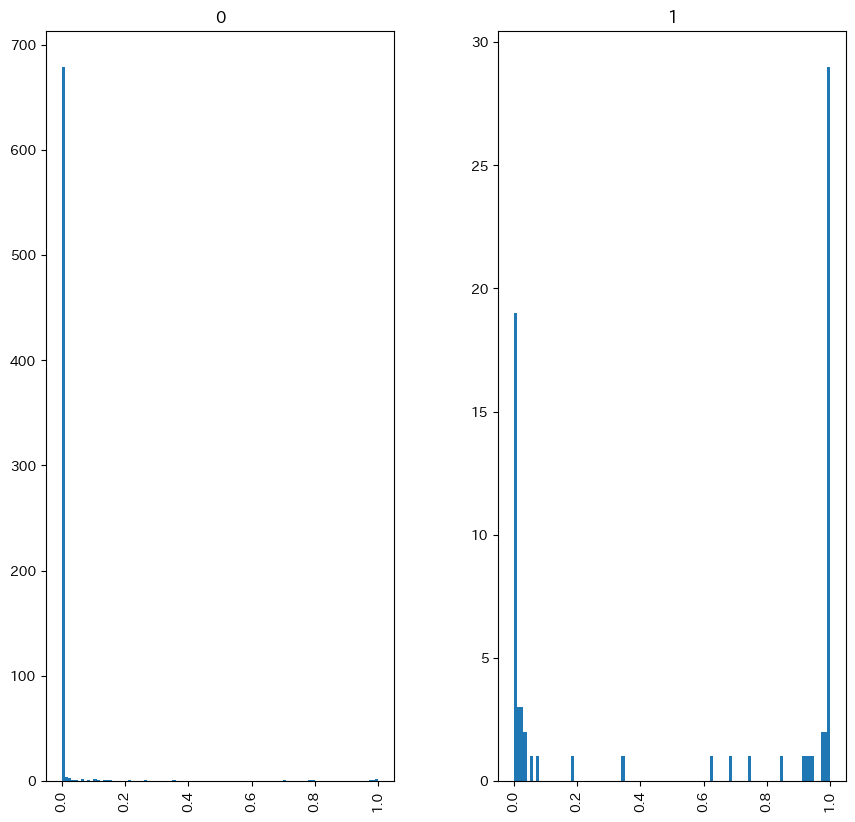

In [87]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_val,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

In [99]:
# テストデータで予測・評価
y_pred = model.predict(X_test, num_iteration=model.best_iteration,predict_disable_shape_check=True)
y_pred_trans = (y_pred > 0.5).astype(int)

# 評価
accuracy = accuracy_score(y_test, y_pred_trans)
precision = precision_score(y_test, y_pred_trans)
recall = recall_score(y_test, y_pred_trans)
f1 = f1_score(y_test, y_pred_trans)
auc=roc_auc_score(y_test, y_pred)

print('Accuracy:', accuracy, "Precision:", precision, "Recall:", recall, "F1:", f1,"AUC:",auc)

Accuracy: 0.9722333955464024 Precision: 0.02549246813441483 Recall: 0.13162393162393163 F1: 0.04271252253501595 AUC: 0.6760155302307277


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

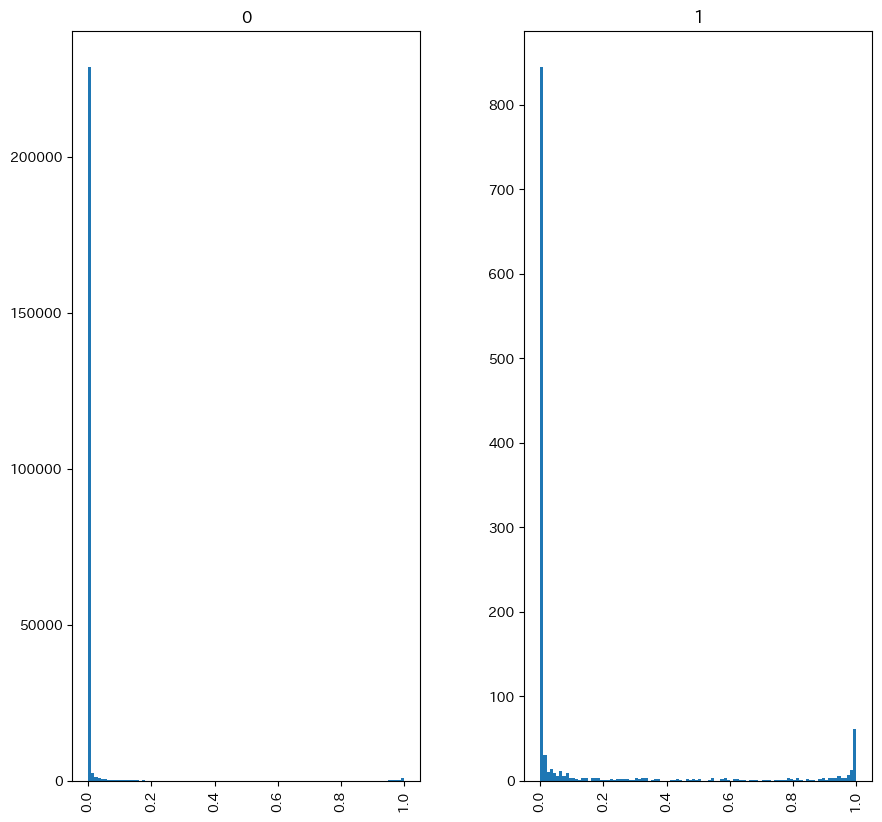

In [100]:
# y_test, y_pred を結合して、y_test 毎に、y_pred のhistogramを作成
y_test_pred=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
y_test_pred["y_pred"].hist(by=y_test_pred["y_test"],bins=100,figsize=(10,10))

Text(0.5, 1.0, 'LightGBM Feature Importance (gain)')

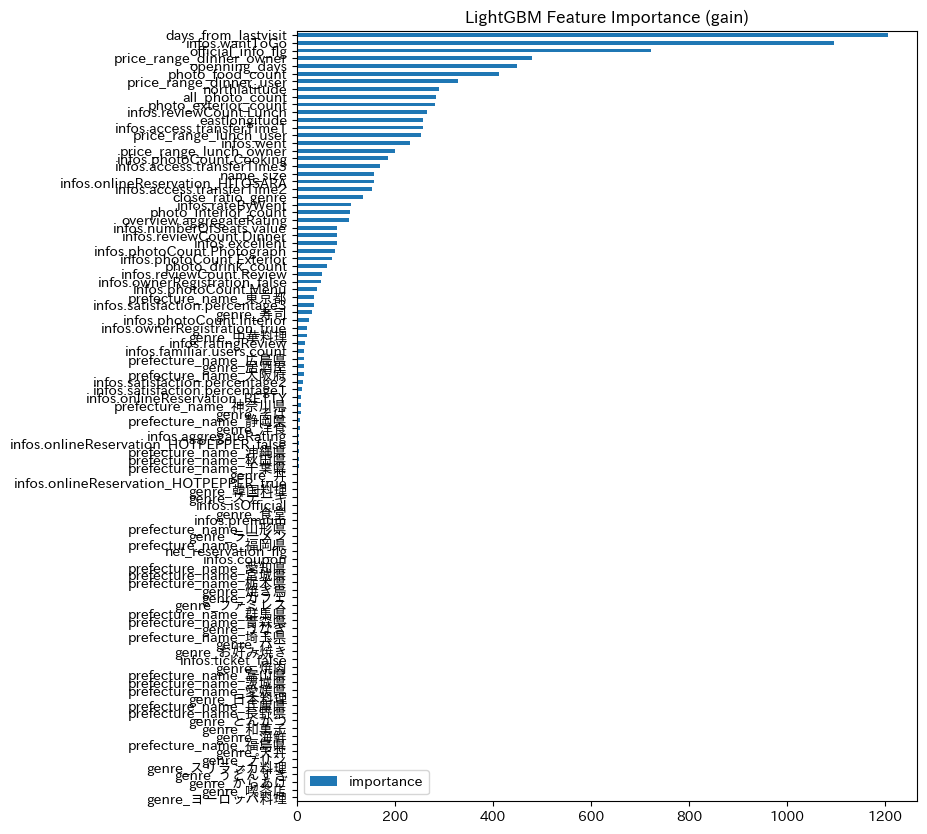

In [101]:
# feature importance
# 日本語を表示するためにフォントを指定

importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=X.columns, columns=['importance'])
importance.sort_values('importance',ascending=False).head(100).sort_values('importance').plot(kind='barh', figsize=(8, 10))
plt.title('LightGBM Feature Importance (gain)')


In [ ]:
importance.sort_values(by="importance",ascending=False).head(20)

,importance
infos.wantToGo,1014.116665
openning_days,342.760433
official_info_flg,274.269609
eastlongitude,256.551422
price_range_lunch_user,250.307883
price_range_dinner_owner,238.163652
photo_exterior_count,224.930975
price_range_dinner_user,224.012551
northlatitude,220.239857
infos.access.transferTime2,205.094326


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


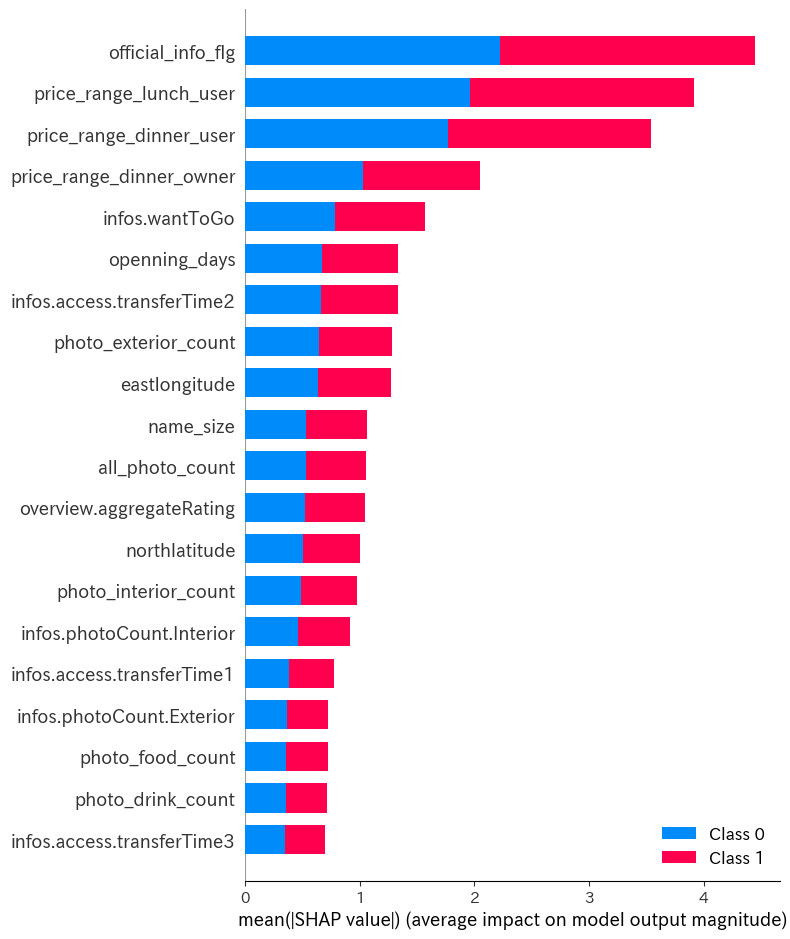

In [ ]:
# shap分析
import shap
shap.initjs()

explainer = shap.TreeExplainer(model=model)

X_test_shap = X_test.head(1000).copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_test_shap)
# shap_values をplot
# サンプルごとのshap_valuesをplot
shap.summary_plot(shap_values, X_test_shap,max_display=20)

In [ ]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')  # または別のバックエンドを選択してください

X_test=X_test.head(1)

explainer = shap.Explainer(model, X_test)
shap_values = explainer.shap_values(X_test)

for i in range(len(X_test)):
    shap.initjs()  # Jupyter Notebookでの可視化を初期化する
    shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])  # 各インスタンスのSHAP値をプロットする
    plt.show()  # プロットを表示する

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
explainer.expected_value

-12.570596654155368

In [ ]:
shap_values[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

X_test_shap = X_test.head(1000)

# 2. 説明変数(特徴量)を渡す
shap_values = explainer(X_test_shap)

In [ ]:
shap.plots.waterfall(shap_values[0])

TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.